In [225]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib as mat
import os
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
import ast
import json
from matplotlib import colors
from PIL import ImageColor
import glob
import matplotlib.ticker as ticker
import pathlib
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.stats import poisson, norm

from sklearn import preprocessing
import re

import scipy.stats as st

from fitter import Fitter

# %#config IPCompleter.greedy=True
# %#matplotlib notebook
# %#matplotlib inline
plt.rcParams["figure.figsize"] = [4, 4]

POINT_PLOT_DODGE = 0.15
sns.set(font_scale=1.25, style="ticks")
FIGSIZE = [6, 6]
plt.style.use("tableau-colorblind10")
# PALETTE = sns.cubehelix_palette(as_cmap\=False, n_colors=3, reverse=False, light=0.7)
print("hot stuff")

hot stuff


In [226]:
def collect_csv_files(root_dir):
    """
    Traverse the directory structure to collect all CSV file paths.

    Args:
    root_dir (str): The root directory where experiments are stored.

    Returns:
    csv_files (list): List of file paths to all CSV files found.
    """
    csv_files = []

    # Walk through all folders and subfolders
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(".csv"):
                csv_files.append(os.path.join(dirpath, filename))

    return csv_files


def clean_column_names(columns, maximum):
    new_columns = []
    interval_pattern = re.compile(
        r"(\d+\.?\d*)[^\d]+([^\s]+)us"
    )  # Pattern to match intervals

    for col in columns:
        if isinstance(col, str):  # Ensure col is a string before processing
            match = interval_pattern.search(col)
            if match:
                start, end = match.groups()
                if end == "x":
                    end = maximum
                new_columns.append(f"{start}-{end}")  # Example: '0-20'
            else:
                new_columns.append(col)

    return new_columns


def parse_and_merge_csv(csv_files):
    """
    Parse all CSV files and merge them into a single DataFrame,
    handling different column structures by filling NaN for missing columns.

    Args:
    csv_files (list): List of file paths to the CSV files.

    Returns:
    merged_df (pd.DataFrame): Merged DataFrame with all data from CSV files.
    """
    dataframes = []

    for file in csv_files:
        # Extract experiment details from the directory structure
        path_parts = file.split(os.sep)
        experiment = path_parts[
            -4
        ]  # Assuming experiment/level/packet_size/output_file.csv
        level = path_parts[-3]
        packet_size = path_parts[-2]

        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)

        if df.columns is None or len(df.columns) == 0:
            print(f"Warning: {file} has no column names or columns are empty.")

        # df.columns = clean_column_names(df.columns)

        # Add metadata columns to identify the experiment, level, and packet size
        df["Experiment"] = experiment
        df["Level"] = int(level)
        df["Packet Size"] = int(packet_size)
        df["IPv4 :Raw priority"] = df["IPv4 :Raw priority"].apply(lambda x: int(x[2], 16))

        # Append the DataFrame to the list
        dataframes.append(df)

    # Merge all DataFrames, handling different columns by filling missing ones with NaN
    merged_df = pd.concat(dataframes, ignore_index=True, sort=False)

    return merged_df


def group_and_clean(df, maximums, groups):
    # Group by 'experiment', 'level', and 'packet_size'
    grouped_df = df.groupby(groups, as_index=False)

    f = dict()

    for index, group in grouped_df:
        # f[index] = clean_column_names(group.dropna(axis=1, how='all'))
        g = group.dropna(axis=1, how="all")
        # print(group['Cut-Through Max Latency (ns)'].max())
        # g.columns = clean_column_names(g, group['Cut-Through Max Latency (ns)'].max()/10**3)

        if index in maximums:
            max_applied = maximums[index]
        else:
            max_applied = (0, maximums[index][1], maximums[index][2])
        g.columns = clean_column_names(g, maximums[index])
        # print(g.columns)
        f[index] = g

    return f


def get_only_bins_per_flowgroup(df, flow_group):
    interval_pattern = re.compile(r".*-.*")  # Pattern for intervals
    interval_columns = [
        col
        for col in df.columns
        if interval_pattern.search(col) and "Latency" not in col
    ]
    df = df[df["Flow Group"] == flow_group]
    return df[interval_columns]

In [227]:
def draw_ecdf_plots(data, lims, save, directory, filename, legend):
    fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=[6, 3])

    linestyle = "solid"  # default
    color_iterator = 0
    extended = False

    for i in range(0, len(data)):
        grp_index = list(data.keys())[i]

        df = data[grp_index]
        df = get_only_bins_per_flowgroup(df, "TE1-foreground - Flow Group 0001")
        # aggregate_bins_df[grp_index] = df

        # x_axis = [float(item.split('-')[1]) - 24 if 'x' not in item else item for item in aggregate_bins_df[grp_index].columns.values]
        # x_axis = [round(float(item.split('-')[1])- 24, 2) if 'x' not in item else item for item in aggregate_bins_df[grp_index].columns.values]
        # x_axis = aggregate_bins_df[grp_index].columns.values
        x_axis = [
            float(item.strip("us").split("-")[1]) - 24 for item in df.columns.values
        ]

        # x_axis[0] = 0

        x = df.sum().cumsum()
        max_val = x[-1]

        ax = None
        if grp_index[-1] == 512:
            ax = ax1[0]
        if grp_index[-1] == 1518:
            ax = ax1[1]

        # (x/max_val).plot(label=grp_index[0],ax=ax)
        lbl = grp_index[0]       
        
        if type(lbl) != np.int64:
            pattern = r"(\w+(?:_\d+)?(?:tc)?)_(\d+gbps)|(\w+tc)"
            match = re.match(pattern, lbl)
            grps = match.groups()
            
            ntc = 1
            if grps[-1] and "tc" in grps[-1]:
                ntc = int(grps[-1].strip("tc"))
            
            datarate = 0
            if grps[-2]:
                datarate = int(grps[-2].strip("gbps"))

            if datarate == 50:
                linestyle = "dashed"
                colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
                ax.plot(
                    x_axis,
                    (x / max_val) * 100,
                    label=lbl,
                    linestyle=linestyle,
                    color=colors[color_iterator],
                )

                color_iterator += 1
                extended = True

                continue

        ax.plot(x_axis, (x / max_val) * 100, label=lbl, linestyle=linestyle)

        packet_size = grp_index[-1]
        ax.set_title(f"Background Traffic:\nPacket Size {packet_size} Byte")

        # plt.show()
    handles, labels = ax1[1].get_legend_handles_labels()
    new_handles = handles

    if "N TC" in legend[0]:
        new_handles = handles[1:]
        new_handles.append(handles[0])

    ax1[1].legend(
        loc="upper left",
        bbox_to_anchor=(1.05, 1.1),
        title=legend[0],
        handles=new_handles,
        labels=legend[1],
    )

    ax1[1].set(xlabel="Latency (μs)", ylabel="Binned-ECDF (%)")

    # edit Tick Labels
    # labels = [float(item.get_text().split('-')[1]) if item.get_text() != '' else item.get_text() for item in ax1[0].get_xticklabels()]

    # Set ticklabels
    # labels = [round(float(item.get_text().split('-')[1]) -24, 2) if 'x' not in item.get_text() else item.get_text() for item in ax1[0].get_xticklabels()]
    # ax1[0].set_xticklabels(labels)
    # ax1[1].set_xticklabels(labels)
    # print(ax1[0].get_xticklabels())

    # set locators
    for i in ax1:
        i.xaxis.set_major_locator(ticker.AutoLocator())
        i.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        i.yaxis.set_major_locator(ticker.AutoLocator())
        i.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        i.set(xlabel="Latency (μs)", ylabel="Binned-ECDF (%)")

    ax1[0].set_xlim(lims)
    ax1[1].set_xlim(lims)
    ax1[0].set_ylim([0, 100])
    ax1[1].set_ylim([0, 100])

    # ax1[1].legend(loc="upper left", bbox_to_anchor=(1, 0.9), title="Level")
    fig.subplots_adjust(hspace=0.8, wspace=0.4)

    # ax1[0].set_title("Background Traffic:\nPacket Size 512 Byte")
    # ax1[1].set_title("Background Traffic:\nPacket Size 1518 Byte")

    sns.despine()

    if save:
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + filename, bbox_inches="tight")


def draw_ecdf_plot(data, lims, save, directory, filename, legend):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])

    for i in range(0, len(data)):
        grp_index = list(data.keys())[i]

        df = data[grp_index]
        df = get_only_bins_per_flowgroup(df, "TE1-foreground - Flow Group 0001")
        # aggregate_bins_df[grp_index] = df

        # x_axis = [float(item.split('-')[1]) - 24 if 'x' not in item else item for item in aggregate_bins_df[grp_index].columns.values]
        # x_axis = [round(float(item.split('-')[1])- 24, 2) if 'x' not in item else item for item in aggregate_bins_df[grp_index].columns.values]
        # x_axis = aggregate_bins_df[grp_index].columns.values
        x_axis = [
            float(item.strip("us").split("-")[1]) - 24 for item in df.columns.values
        ]

        # x_axis[0] = 0

        x = df.sum().cumsum()
        max_val = x[-1]

        # (x/max_val).plot(label=grp_index[0],ax=ax)
        ax1.plot(x_axis, (x / max_val) * 100, label=grp_index[1])

        packet_size = grp_index[1]
        ax1.set_title(f"Background Traffic:\nPacket Size {packet_size} Byte")

    # plt.show()
    ax1.legend(
        loc="upper left", bbox_to_anchor=(1.05, 1.1), title=legend[0], labels=legend[1]
    )
    ax1.set(xlabel="Latency (μs)", ylabel="Binned-ECDF (%)")

    # edit Tick Labels
    # labels = [float(item.get_text().split('-')[1]) if item.get_text() != '' else item.get_text() for item in ax1[0].get_xticklabels()]

    # Set ticklabels
    # labels = [round(float(item.get_text().split('-')[1]) -24, 2) if 'x' not in item.get_text() else item.get_text() for item in ax1[0].get_xticklabels()]
    # ax1[0].set_xticklabels(labels)
    # ax1[1].set_xticklabels(labels)
    # print(ax1[0].get_xticklabels())

    # set locators
    ax1.xaxis.set_major_locator(ticker.AutoLocator())
    ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.yaxis.set_major_locator(ticker.AutoLocator())
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.set(xlabel="Latency (μs)", ylabel="Binned-ECDF (%)")

    ax1.set_xlim(lims)
    ax1.set_ylim([0, 100])

    # ax1.legend(loc="upper left", bbox_to_anchor=(1, 0.9), title="Level")
    fig.subplots_adjust(hspace=0.8, wspace=0.4)

    sns.despine()

    if save:
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + filename, bbox_inches="tight")

# E1.1

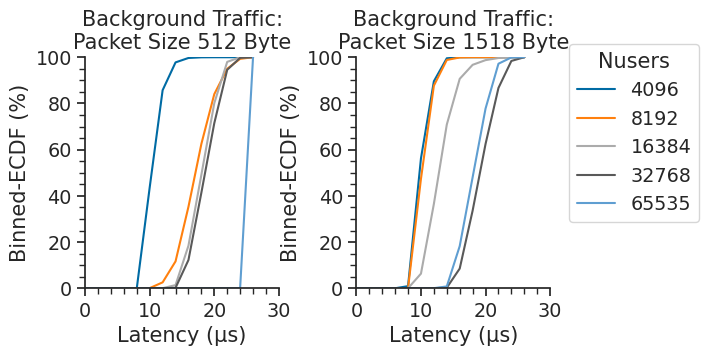

In [228]:
DIR = f"/home/rubinhus/code/datasets/smartqos_final/"
FILENAME = "Latency Bins"
EXPERIMENT = "e1_1"

maximums_nusers = {
    (4096, 512): 50,
    (4096, 1518): 50,
    (8192, 512): 50,
    (8192, 1518): 50,
    (16384, 512): 50,
    (16384, 1518): 50,
    (32768, 512): 50,
    (32768, 1518): 50,
    (65535, 512): 50,
    (65535, 1518): 50,
}

legend = ("Nusers", [4096, 8192, 16384, 32768, 65535])

csv_files = collect_csv_files(DIR + EXPERIMENT)
merged_df = parse_and_merge_csv(csv_files)
groups = group_and_clean(merged_df, maximums_nusers, ["Level", "Packet Size"])
draw_ecdf_plots(
    groups, [0, 30], True, DIR + "output_files/", f"{EXPERIMENT}_ecdf.pdf", legend
)

# E 1.2

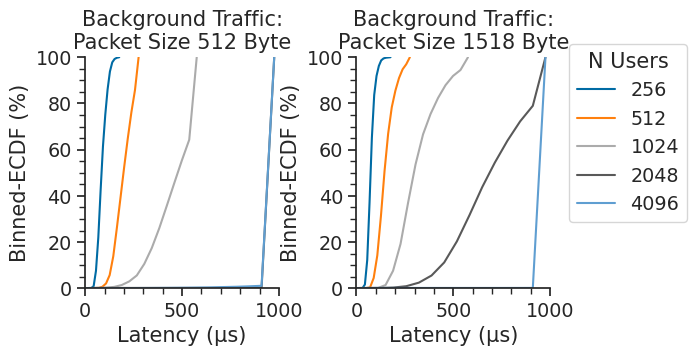

In [200]:
DIR = f"/home/rubinhus/code/datasets/smartqos_final/"
FILENAME = "Latency Bins"
EXPERIMENT = "e1_2"

maximums_nusers = {
    (256, 512): 200,
    (256, 1518): 200,
    (512, 512): 300,
    (512, 1518): 300,
    (1024, 512): 600,
    (1024, 1518): 600,
    (2048, 512): 1000,
    (2048, 1518): 1000,
    (4096, 512): 1000,
    (4096, 1518): 1000,
}

legend = ("N Users", [256, 512, 1024, 2048, 4096])

csv_files = collect_csv_files(DIR + EXPERIMENT)
merged_df = parse_and_merge_csv(csv_files)
groups = group_and_clean(merged_df, maximums_nusers, ["Level", "Packet Size"])
draw_ecdf_plots(
    groups, [0, 1000], True, DIR + "output_files/", f"{EXPERIMENT}_ecdf.pdf", legend
)

# E1.4

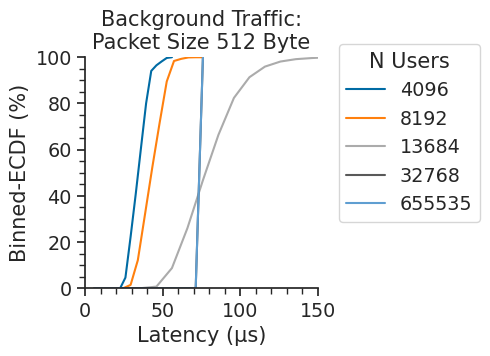

In [201]:
DIR = f"/home/rubinhus/code/datasets/smartqos_final/"
FILENAME = "Latency Bins"
EXPERIMENT = "e1_4_512"

maximums_nusers = {
    (4096, 512): 80,
    (8192, 512): 100,
    (16384, 512): 180,
    (32768, 512): 100,
    (65535, 512): 100,
}

legend = ("N Users", [4096, 8192, 13684, 32768, 655535])

csv_files = collect_csv_files(DIR + EXPERIMENT)
merged_df = None
merged_df = parse_and_merge_csv(csv_files)
groups_e1_4_512 = group_and_clean(merged_df, maximums_nusers, ["Level", "Packet Size"])
draw_ecdf_plot(
    groups_e1_4_512,
    [0, 150],
    True,
    DIR + "output_files/",
    f"{EXPERIMENT}_ecdf.pdf",
    legend,
)

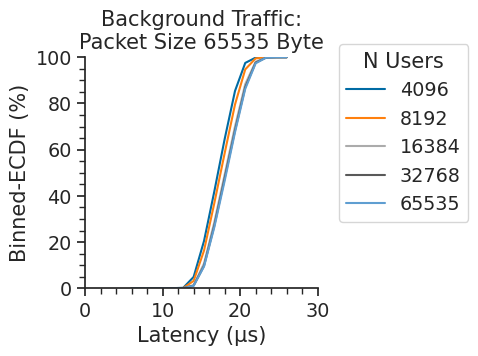

In [202]:
DIR = f"/home/rubinhus/code/datasets/smartqos_final/"
FILENAME = "Latency Bins"
EXPERIMENT = "e1_4_1518_20gbps"

maximums_nusers = {
    ("e1_4_1518_20gbps", 4096, 1518): 50,
    ("e1_4_1518_20gbps", 8192, 1518): 50,
    ("e1_4_1518_20gbps", 16384, 1518): 50,
    ("e1_4_1518_20gbps", 32768, 1518): 50,
    ("e1_4_1518_20gbps", 65535, 1518): 50,
}

legend = ("N Users", [4096, 8192, 16384, 32768, 65535])

csv_files = collect_csv_files(DIR + EXPERIMENT)
merged_df = None
merged_df = parse_and_merge_csv(csv_files)
groups_e1_4_1518_20gbps = group_and_clean(
    merged_df, maximums_nusers, ["Experiment", "Level", "Packet Size"]
)
draw_ecdf_plot(
    groups_e1_4_1518_20gbps,
    [0, 30],
    True,
    DIR + "output_files/",
    f"{EXPERIMENT}_ecdf.pdf",
    legend,
)

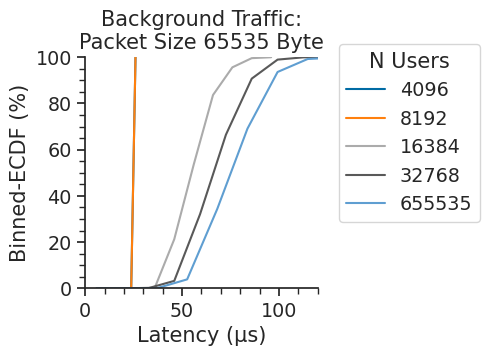

In [203]:
DIR = f"/home/rubinhus/code/datasets/smartqos_final/"
FILENAME = "Latency Bins"
EXPERIMENT = "e1_4_1518_50gbps"

maximums_nusers = {
    ("e1_4_1518_50gbps", 4096, 1518): 50,
    ("e1_4_1518_50gbps", 8192, 1518): 50,
    ("e1_4_1518_50gbps", 16384, 1518): 120,
    ("e1_4_1518_50gbps", 32768, 1518): 150,
    ("e1_4_1518_50gbps", 65535, 1518): 170,
}

legend = ("N Users", [4096, 8192, 16384, 32768, 655535, "50 Gbps"])

csv_files = collect_csv_files(DIR + EXPERIMENT)
merged_df = None
merged_df = parse_and_merge_csv(csv_files)
groups_e1_4_1518_50gbps = group_and_clean(
    merged_df, maximums_nusers, ["Experiment", "Level", "Packet Size"]
)
draw_ecdf_plot(
    groups_e1_4_1518_50gbps,
    [0, 120],
    True,
    DIR + "output_files/",
    f"{EXPERIMENT}_ecdf.pdf",
    legend,
)

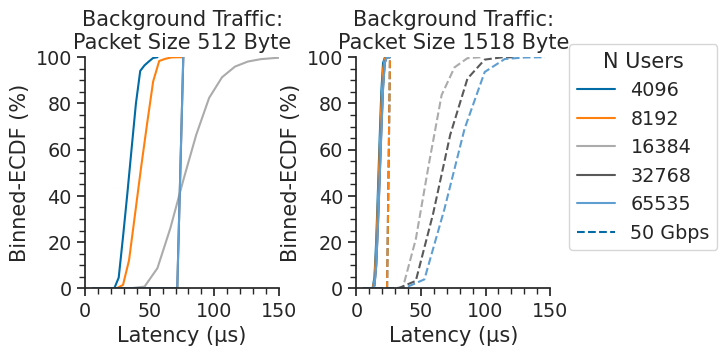

In [204]:
legend = ("N Users", [4096, 8192, 16384, 32768, 65535, '50 Gbps'])

groups = {}
groups.update(groups_e1_4_512)
groups.update(groups_e1_4_1518_20gbps)
groups.update(groups_e1_4_1518_50gbps)

draw_ecdf_plots(
    groups, [0, 150], True, DIR + "output_files/", f"{EXPERIMENT}_ecdf.pdf", legend
)

# E 2.1

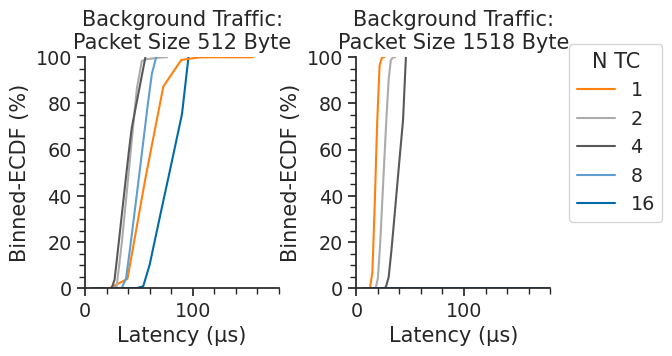

In [249]:
DIR = f"/home/rubinhus/code/datasets/smartqos_final_e2_1/"
FILENAME = "Latency Bins"
EXPERIMENT = "smartqos_final_e2_1"

maximums_nusers = {
    ("1tc_20gbps", 512): 180,
    ("1tc_20gbps", 1518): 50,
    ("2tc_20gbps", 512): 100,
    ("2tc_20gbps", 1518): 60,
    ("4tc_20gbps", 512): 80,
    ("4tc_20gbps", 1518): 70,
    ("8tc_20gbps", 512): 90,
    ("8tc_20gbps", 1518): 800,
    ("16tc_20gbps", 512): 120,
    ("16tc_20gbps", 1518): 1300,
}

legend = ("N TC", [1, 2, 4, 8, 16])

csv_files = collect_csv_files(DIR + EXPERIMENT)
merged_df = parse_and_merge_csv(csv_files)
groups_1518_20gbps = group_and_clean(merged_df, maximums_nusers, ["Experiment", "Packet Size"])
draw_ecdf_plots(
    groups_1518_20gbps, [0, 180], False, DIR + "output_files/", f"{EXPERIMENT}_ecdf.pdf", legend
)

In [254]:
merged_df.groupby( ["Experiment", "Packet Size"])['Rx Frame Rate'].describe()

,,count,mean,std,min,25%,50%,75%,max
Experiment,Packet Size,,,,,,,,
16tc_50gbps,1518,480.0,2.412381e+05,6.234093e+04,44.5,257197.875,257290.5,257383.500,257703.5
1tc_50gbps,1518,60.0,2.058649e+06,2.075976e+06,44.5,45.000,2058629.0,4117249.750,4117314.5
2tc_50gbps,1518,90.0,1.372436e+06,9.758633e+05,44.5,45.000,2058628.5,2058632.500,2058640.5
4tc_50gbps,1518,150.0,8.234609e+05,4.130872e+05,44.5,1029312.125,1029314.0,1029316.000,1029320.0
8tc_50gbps,1518,270.0,4.574934e+05,1.620328e+05,44.5,514588.625,514666.5,514721.875,514999.0


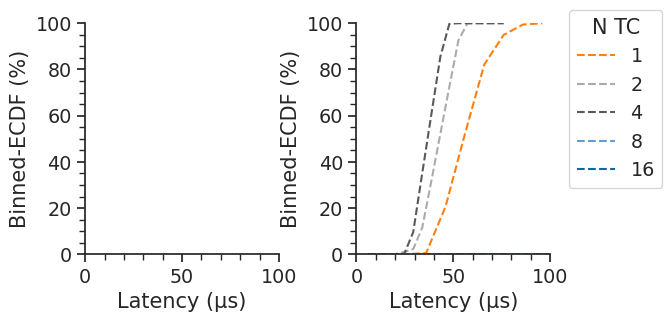

In [253]:
DIR = f"/home/rubinhus/code/datasets/smartqos_final_e2_1/"
FILENAME = "Latency Bins"
EXPERIMENT = "smartqos_final_e2_1_50gbps"

maximums_nusers = {
    ("1tc_50gbps", 1518): 120,
    ("2tc_50gbps", 1518): 100,
    ("4tc_50gbps", 1518): 100,
    ("8tc_50gbps", 1518): 1300,
    ("16tc_50gbps", 1518): 1300,
}

legend = ("N TC", [1, 2, 4, 8, 16])

csv_files = collect_csv_files(DIR + EXPERIMENT)
merged_df = parse_and_merge_csv(csv_files)
groups_1518_50gbps = group_and_clean(merged_df, maximums_nusers, ["Experiment", "Packet Size"])
draw_ecdf_plots(
    groups_1518_50gbps, [0, 100], False, DIR + "output_files/", f"{EXPERIMENT}_ecdf.pdf", legend
)

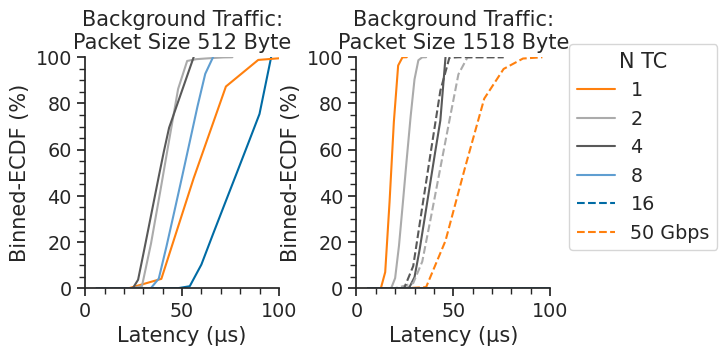

In [239]:
legend = ("N TC", [1, 2, 4, 8, 16, '50 Gbps'])

groups = {}
groups.update(groups_1518_20gbps)
groups.update(groups_1518_50gbps)

draw_ecdf_plots(
    groups, [0, 100], True, DIR + "output_files/", f"{EXPERIMENT}_ecdf.pdf", legend
)

# E 2.2

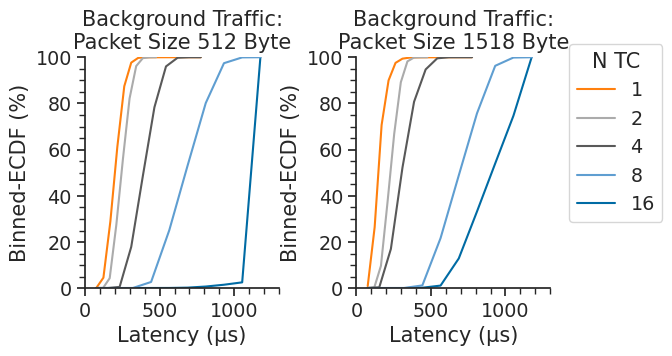

In [224]:
DIR = f"/home/rubinhus/code/datasets/smartqos_final/"
FILENAME = "Latency Bins"
EXPERIMENT = "e2_2"

maximums_nusers = {
    ("1tc", 512): 800,
    ("1tc", 1518): 800,
    ("2tc", 512): 500,
    ("2tc", 1518): 500,
    ("4tc", 512): 800,
    ("4tc", 1518): 800,
    ("8tc", 512): 1200,
    ("8tc", 1518): 1200,
    ("16tc", 512): 1200,
    ("16tc", 1518): 1200,
}

legend = ("N TC", [1, 2, 4, 8, 16])

csv_files = collect_csv_files(DIR + EXPERIMENT)
merged_df = parse_and_merge_csv(csv_files)
groups = group_and_clean(merged_df, maximums_nusers, ["Experiment", "Packet Size"])
draw_ecdf_plots(
    groups, [0, 1300], True, DIR + "output_files/", f"{EXPERIMENT}_ecdf.pdf", legend
)